# Model Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import shap
from xgboost import XGBRegressor
from ngboost import NGBRegressor

In [ ]:
original_df = pd.read_csv('/home/javialbert/datasets/ICC_thpt_estimation/v1_6_1_data_and_models/data_df.csv')
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
original_df = original_df[original_df.carrier.isin(['CARRIER1', 'CARRIER2', 'CARRIER3'])]

## Constant Definition

In [ ]:
# Tune these
folder_dir = '/home/javialbert/datasets/ICC_thpt_estimation/v1_6_1_data_and_models/'

verbose = True

N_ESTIMATORS = 1000 # 1000
PATIENCE_GB = 100 # 100
LR_GB = 0.05

RANDOM_SEED = 42 # 42

technologies = ['4G', '5G_NSA', '5G_SA'] 

split_dates = {'train' : {'start' : '2024-05-01', 
                            'end' : '2025-08-18'},
                'val' : {'start' : '2025-08-18',
                        'end' : '2025-08-26'},
                'test' : {'start' : '2025-08-26',
                        'end' : '2025-09-10'}}

# All features
features = ['Latency', 'Jitter',
       'Packet Loss', 'DL Throughput', 'DL TTFB', 'RSRP',
       'RSRQ', 'SINR', 'Timing Advance',
       'Frequency Band', 'Carrier']

# Target variable
target = 'DL Throughput'

## Function Definition

In [ ]:
def train_val_test_split(data_df, technology, features, split_dates):

    data_df = data_df.loc[data_df['radio_access_technology'].isin([technology])]
    data_df = data_df[['timestamp'] + features]
    
    # Totd Conversion
    data_df['time_of_day'] = (data_df["timestamp"].dt.hour 
                                + data_df["timestamp"].dt.minute / 60
                                + data_df["timestamp"].dt.second / 3600)
    data_df["weekday"] = data_df.timestamp.dt.weekday.astype(int)

    # Train val test split
    train_df = data_df.loc[(data_df['timestamp'] >= split_dates['train']['start']) & (data_df['timestamp'] < split_dates['train']['end'])]
    val_df = data_df.loc[(data_df['timestamp'] >= split_dates['val']['start']) & (data_df['timestamp'] < split_dates['val']['end'])]
    test_df = data_df.loc[(data_df['timestamp'] >= split_dates['test']['start']) & (data_df['timestamp'] < split_dates['test']['end'])]

    train_df = train_df[features + ['time_of_day', 'weekday']]
    val_df = val_df[features + ['time_of_day', 'weekday']]
    test_df = test_df[features + ['time_of_day', 'weekday']]

    train_df['carrier'] = train_df['carrier'].astype("category").cat.codes
    val_df['carrier'] = val_df['carrier'].astype("category").cat.codes
    test_df['carrier'] = test_df['carrier'].astype("category").cat.codes

    return train_df, val_df, test_df

## Training Loop

In [5]:
for tech in technologies:
    tech_dir = os.path.join(folder_dir, tech)
    os.makedirs(tech_dir, exist_ok=True)

In [ ]:
# Loop
for technology in technologies:

    save_dir = os.path.join(folder_dir, technology)
    if verbose: print(technology)
    
    # Train val test split
    tech_df = original_df.copy(deep=True)
    train_df, val_df, test_df = train_val_test_split(tech_df, technology, features, split_dates)
    if verbose: print('Train, val, test split done')
    if verbose: print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    if verbose: print('Normalizing target variable')
    train_df['DL Throughput'] = np.log1p(train_df['DL Throughput'])
    val_df['DL Throughput'] = np.log1p(val_df['DL Throughput'])
    test_df['DL Throughput'] = np.log1p(test_df['DL Throughput'])

    ## Keep normalization values
    thpt_train_mean = train_df['DL Throughput'].dropna().mean()
    thpt_train_std = train_df['DL Throughput'].dropna().std()

    m = thpt_train_mean
    s = thpt_train_std
    train_df['DL Throughput'] = (train_df['DL Throughput'] - m) / s
    val_df['DL Throughput'] = (val_df['DL Throughput'] - m) / s
    test_df['DL Throughput'] = (test_df['DL Throughput'] - m) / s
    if verbose: print('Throughput normalized')

    # Convert pandas to numpy vectors: X_train, X_val and X_test
    X_train = train_df[features].values.astype('float32')
    y_train = train_df['DL Throughput'].values.astype('float32').reshape(-1, 1)
    X_val = val_df[features].values.astype('float32')
    y_val = val_df['DL Throughput'].values.astype('float32').reshape(-1, 1)
    X_test = test_df[features].values.astype('float32')
    y_test = test_df['DL Throughput'].values.astype('float32').reshape(-1, 1)

    total_samples = len(y_train) + len(y_val) + len(y_test)
    train_size = X_train.shape[0]
    d = X_train.shape[1]
    if verbose: print('Training arrays computed')
    if verbose: print('Train/val/test proportions:', round(len(y_train) / total_samples,2), '/', 
                                        round(len(y_val) / total_samples,2), '/',
                                        round(len(y_test) / total_samples,2))

    # Saving datasets
    np.save(os.path.join(save_dir, "X_train.npy"), X_train)
    np.save(os.path.join(save_dir, "X_val.npy"), X_val)
    np.save(os.path.join(save_dir, "X_test.npy"), X_test)
    np.save(os.path.join(save_dir, "y_train.npy"), y_train)
    np.save(os.path.join(save_dir, "y_val.npy"), y_val)
    np.save(os.path.join(save_dir, "y_test.npy"), y_test)
    np.save(os.path.join(save_dir, "m.npy"), thpt_train_mean)
    np.save(os.path.join(save_dir, "s.npy"), thpt_train_std)
    np.save(os.path.join(save_dir, "features_lst.npy"), np.array(features))
    if verbose: print('Datasets saved')

    if verbose: print('XGBoost model starting')

    # XGBoost model definition
    xgb_model = XGBRegressor(n_estimators=N_ESTIMATORS, max_depth=6, learning_rate=LR_GB, 
                        eval_metric=["rmse", "mae"], early_stopping_rounds = PATIENCE_GB,
                        random_state=RANDOM_SEED)
    if verbose: print('XGBoost model defined')

    # XGBRegressor 
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  
        verbose=True,
    )
    if verbose: print('XGBoost model trained')
    if verbose: print(xgb_model.best_iteration)

    xgb_model.save_model(os.path.join(save_dir, "xgb_model.json"))
    if verbose: print('XGBoost model saved')

    # XGBoost SHAP
    if verbose: print('XGBoost SHAP starting')
    
    X_shap = X_test.copy()
    if verbose: print('Shap values reset')
    
    explainer = shap.TreeExplainer(xgb_model, X_shap, feature_names=features)
    shap_values = explainer(X_shap)

    if verbose: print('XGBoost SHAP ended')

    # Saving shap
    with open(os.path.join(save_dir, "xgb_shap.pkl"), "wb") as f:
        pickle.dump(shap_values, f)
    ax = shap.plots.beeswarm(shap_values, max_display=20, show=False)
    fig = ax.get_figure() 
    fig.savefig(os.path.join(save_dir, "xgboost_shap_beeswarm.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
    plt.close()
    if verbose: print('XGBoost shap saved')
    if verbose: print('-------------------------------------------------------------')
    
    del xgb_model
    del explainer, shap_values, X_shap

    if verbose: print('NGBoost model starting')
    ngb_model = NGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=LR_GB,
                    early_stopping_rounds=PATIENCE_GB,random_state=RANDOM_SEED)
    ngb_model.fit(X_train, y_train,
              X_val=X_val,
              Y_val=y_val);

    if verbose: print('NGBoost model trained')

    with open(os.path.join(save_dir, "ngboost_model.pkl"), "wb") as f:
        pickle.dump(ngb_model, f)

    if verbose: print('NGBoost model saved')

    # NGBoost SHAP
    if verbose: print('NGBoost SHAP starting')
    
    X_shap = X_test.copy()
    if verbose: print('Shap values reset')

    # NGBoost SHAP - mean
    explainer_mean = shap.TreeExplainer(ngb_model, model_output=0, feature_names=features)
    shap_values_ng_mean = explainer_mean(X_shap)

    if verbose: print('NGBoost mean SHAP ended')
    
    # Saving shap
    with open(os.path.join(save_dir, "ngb_mean_shap.pkl"), "wb") as f:
        pickle.dump(shap_values_ng_mean, f)
    ax = shap.plots.beeswarm(shap_values_ng_mean, max_display=20, show=False)
    fig = ax.get_figure() 
    fig.savefig(os.path.join(save_dir, "ngboost_mean_shap_beeswarm.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
    plt.close()
    if verbose: print('NGBoost mean shap saved')

    # NGBoost SHAP - std
    X_shap = X_test.copy()

    explainer_std = shap.TreeExplainer(ngb_model, model_output=1, feature_names=features) 
    shap_values_ng_std = explainer_std(X_shap)

    if verbose: print('NGBoost std SHAP ended')

    # Saving shap
    with open(os.path.join(save_dir, "ngb_std_shap.pkl"), "wb") as f:
        pickle.dump(shap_values_ng_std, f)
    ax = shap.plots.beeswarm(shap_values_ng_std, max_display=20, show=False)
    fig = ax.get_figure() 
    fig.savefig(os.path.join(save_dir, "ngboost_std_shap_beeswarm.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
    plt.close()
    if verbose: print('NGBoost mean shap saved')

    # Make sure we re-initialize before going to the next round
    del ngb_model
    del explainer_mean, explainer_std, shap_values_ng_mean, shap_values_ng_std, X_shap
    del X_train, y_train, X_val, y_val, X_test, y_test
    del train_df, val_df, test_df

4G
Train, val, test split done
Train: 166916, Val: 23305, Test: 45319
Columns renamed
Normalizing target variable
Throughput normalized
Training arrays computed
Train/val/test proportions: 0.71 / 0.1 / 0.19
Datasets saved
XGBoost model starting
XGBoost model defined
[0]	validation_0-rmse:0.97466	validation_0-mae:0.75836	validation_1-rmse:0.98426	validation_1-mae:0.76574
[1]	validation_0-rmse:0.95111	validation_0-mae:0.73982	validation_1-rmse:0.95987	validation_1-mae:0.74665
[2]	validation_0-rmse:0.92924	validation_0-mae:0.72253	validation_1-rmse:0.93731	validation_1-mae:0.72889
[3]	validation_0-rmse:0.90887	validation_0-mae:0.70633	validation_1-rmse:0.91634	validation_1-mae:0.71237
[4]	validation_0-rmse:0.88990	validation_0-mae:0.69107	validation_1-rmse:0.89668	validation_1-mae:0.69676
[5]	validation_0-rmse:0.87235	validation_0-mae:0.67698	validation_1-rmse:0.87879	validation_1-mae:0.68252
[6]	validation_0-rmse:0.85592	validation_0-mae:0.66367	validation_1-rmse:0.86174	validation_1-mae

100%|===================| 45259/45319 [11:01<00:00]        

XGBoost SHAP ended
XGBoost shap saved
-------------------------------------------------------------
NGBoost model starting
Using passed validation data to check for early stopping.
[iter 0] loss=1.4189 val_loss=1.3853 scale=1.0000 norm=1.0000
[iter 100] loss=0.9391 val_loss=0.9409 scale=1.0000 norm=0.7698
[iter 200] loss=0.9174 val_loss=0.9259 scale=1.0000 norm=0.7694
[iter 300] loss=0.9099 val_loss=0.9210 scale=1.0000 norm=0.7677
[iter 400] loss=0.9046 val_loss=0.9187 scale=1.0000 norm=0.7660
[iter 500] loss=0.9000 val_loss=0.9175 scale=1.0000 norm=0.7642
[iter 600] loss=0.8965 val_loss=0.9171 scale=1.0000 norm=0.7630
[iter 700] loss=0.8932 val_loss=0.9168 scale=1.0000 norm=0.7618
== Early stopping achieved.
== Best iteration / VAL676 (val_loss=0.9167)
NGBoost model trained
NGBoost model saved
NGBoost SHAP starting
Shap values reset
NGBoost mean SHAP ended
NGBoost mean shap saved
NGBoost std SHAP ended
NGBoost mean shap saved
5G_NSA_CONNECTED
Train, val, test split done
Train: 24572, 

100%|===================| 6835/6864 [00:49<00:00]        

XGBoost SHAP ended
XGBoost shap saved
-------------------------------------------------------------
NGBoost model starting
Using passed validation data to check for early stopping.
[iter 0] loss=1.4189 val_loss=1.4126 scale=1.0000 norm=1.0000
[iter 100] loss=1.0045 val_loss=1.0918 scale=1.0000 norm=0.7974
[iter 200] loss=0.9735 val_loss=1.0795 scale=1.0000 norm=0.7918
[iter 300] loss=0.9551 val_loss=1.0838 scale=1.0000 norm=0.7852
== Early stopping achieved.
== Best iteration / VAL208 (val_loss=1.0770)
NGBoost model trained
NGBoost model saved
NGBoost SHAP starting
Shap values reset
NGBoost mean SHAP ended
NGBoost mean shap saved
NGBoost std SHAP ended
NGBoost mean shap saved
5G_SA
Train, val, test split done
Train: 7094, Val: 994, Test: 1830
Columns renamed
Normalizing target variable
Throughput normalized
Training arrays computed
Train/val/test proportions: 0.72 / 0.1 / 0.18
Datasets saved
XGBoost model starting
XGBoost model defined
[0]	validation_0-rmse:0.97617	validation_0-mae:0.7

# Plots

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import seaborn as sns
from xgboost import XGBRegressor
from ngboost import NGBRegressor

In [ ]:
folder_dir = '/home/javialbert/datasets/ICC_thpt_estimation/v1_6_data_and_models/'

dir_dict = {'4G' : folder_dir+'4G/',
            '5G_NSA' : folder_dir+'5G_NSA/',
            '5G_SA' : folder_dir+'5G_SA/'
            }

In [ ]:
model_data_dict = {}

for tech in dir_dict:
    model_data_dict[tech] = {}
    X_train = np.load(os.path.join(dir_dict[tech], "X_train.npy"))
    y_train = np.load(os.path.join(dir_dict[tech], "y_train.npy"))
    X_val = np.load(os.path.join(dir_dict[tech], "X_val.npy"))
    y_val = np.load(os.path.join(dir_dict[tech], "y_val.npy"))
    y_test = np.load(os.path.join(dir_dict[tech], "y_test.npy"))
    X_test = np.load(os.path.join(dir_dict[tech], "X_test.npy"))
    m = np.load(os.path.join(dir_dict[tech], "m.npy"))
    s = np.load(os.path.join(dir_dict[tech], "s.npy"))
    X_shap = X_test.copy()
    features = np.load(os.path.join(dir_dict[tech], "features_lst.npy"), allow_pickle=True) 
    shap_features = features
    
    with open(os.path.join(dir_dict[tech], "xgb_shap.pkl"), "rb") as f:
        xgb_shap = pickle.load(f)

    with open(os.path.join(dir_dict[tech], "ngb_mean_shap.pkl"), "rb") as f:
        ngboost_shap_mean = pickle.load(f)

    with open(os.path.join(dir_dict[tech], "ngb_std_shap.pkl"), "rb") as f:
        ngboost_shap_std = pickle.load(f)

    train_size = X_train.shape[0]
    d = X_train.shape[1]

    xgb_model = XGBRegressor()
    xgb_model.load_model(os.path.join(dir_dict[tech], "xgb_model.json"))

    with open(os.path.join(dir_dict[tech], "ngboost_model.pkl"), "rb") as f:
        ngb_model = pickle.load(f)

    model_data_dict[tech]['xgb_model'] = xgb_model
    model_data_dict[tech]['ngb_model'] = ngb_model
    model_data_dict[tech]['X_train'] = X_train
    model_data_dict[tech]['y_train'] = y_train
    model_data_dict[tech]['X_val'] = X_val
    model_data_dict[tech]['y_val'] = y_val
    model_data_dict[tech]['X_test'] = X_test
    model_data_dict[tech]['y_test'] = y_test
    model_data_dict[tech]['X_shap'] = X_shap
    model_data_dict[tech]['features'] = features
    model_data_dict[tech]['m'] = float(m)
    model_data_dict[tech]['s'] = float(s)
    model_data_dict[tech]['shap_features'] = shap_features
    model_data_dict[tech]['xgb_shap'] = xgb_shap
    model_data_dict[tech]['ngb_shap_mean'] = ngboost_shap_mean
    model_data_dict[tech]['ngb_shap_std'] = ngboost_shap_std

/home/javialbert/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fig 1. Input data characteristics

Count of 4G, 5G NSA and 5G SA samples
% missing values for latency, sinr, TA and rest

Feature list, winsorization values, standarization and description of processing.

## Fig 2. Accuracy Plots

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.special import erf

def _phi(z):  # standard normal pdf
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z * z)

def _Phi(z):  # standard normal cdf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def crps_gaussian(mu, sigma, y, eps=1e-12):
    sigma = np.maximum(np.asarray(sigma, dtype=float), eps).flatten()
    mu = np.asarray(mu, dtype=float).flatten()
    y = np.asarray(y, dtype=float).flatten()
    z = (y - mu) / sigma
    return sigma * (z * (2.0 * _Phi(z) - 1.0) + 2.0 * _phi(z) - 1.0 / np.sqrt(np.pi))


In [5]:
metrics_dict = {}
for tech in model_data_dict:
    metrics_dict[tech] = {}
    xgb_model = model_data_dict[tech]['xgb_model']
    ngb_model = model_data_dict[tech]['ngb_model']
    X_test = model_data_dict[tech]['X_test']
    y_test = model_data_dict[tech]['y_test']
    m = model_data_dict[tech]['m']
    s = model_data_dict[tech]['s']

    y_test_nat = np.expm1(y_test * s + m)

    # ---- XGB metrics ----
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_xgb_nat = np.expm1(y_pred_xgb * s + m)
    metrics_dict[tech]['xgb_model'] = {
        'mae': mean_absolute_error(y_test, y_pred_xgb),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'r2': r2_score(y_test, y_pred_xgb),
        'crps': mean_absolute_error(y_test, y_pred_xgb),
        'mae_nats' : mean_absolute_error(y_test_nat, y_pred_xgb_nat),
        'rmse_nats' : np.sqrt(mean_squared_error(y_test_nat, y_pred_xgb_nat))
    }

    # ---- NGB metrics ----
    y_pred_dist_ng = ngb_model.pred_dist(X_test)  # predictive distribution
    mu = y_pred_dist_ng.mean().flatten()
    sigma = y_pred_dist_ng.std().flatten()
    y_pred_mean_ng = y_pred_dist_ng.mean()  # mean prediction
    y_pred_mean_nat_ng = np.expm1(y_pred_mean_ng * s + m)
    metrics_dict[tech]['ngb_model'] = {
        'mae': mean_absolute_error(y_test, y_pred_mean_ng),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_mean_ng)),
        'r2': r2_score(y_test, y_pred_mean_ng),
        'crps': np.mean(crps_gaussian(mu, sigma, y_test)),
        'mae_nats' : mean_absolute_error(y_test_nat, y_pred_mean_nat_ng),
        'rmse_nats' : np.sqrt(mean_squared_error(y_test_nat, y_pred_mean_nat_ng))
    }

In [6]:
# ---- Convert to DataFrame and round to 2 decimals ----
df_metrics = pd.DataFrame.from_dict(
    {(tech, model): metrics_dict[tech][model] 
     for tech in metrics_dict.keys() 
     for model in metrics_dict[tech].keys()},
    orient='index'
)

df_metrics = df_metrics.round(4) # apply only to this DataFrame
print(df_metrics)

                     mae    rmse      r2    crps    mae_nats   rmse_nats
4G     xgb_model  0.4677  0.6362  0.5837  0.4677  13875.2334  21282.8720
       ngb_model  0.4704  0.6374  0.5821  0.3371  14003.6427  21450.5163
5G_NSA xgb_model  0.5297  0.7068  0.4624  0.5297  42597.9961  57529.5881
       ngb_model  0.5345  0.7101  0.4574  0.3777  43227.5745  58397.9230
5G_SA  xgb_model  0.5488  0.8305  0.3987  0.5488  49458.0039  63500.1178
       ngb_model  0.5461  0.8238  0.4085  0.3980  49722.9607  63869.9413


## Fig 3. CI Plots Example

In [7]:
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
CI_PERCENTILE = 0.95
z = scipy.stats.norm.ppf(0.5 + CI_PERCENTILE/2)

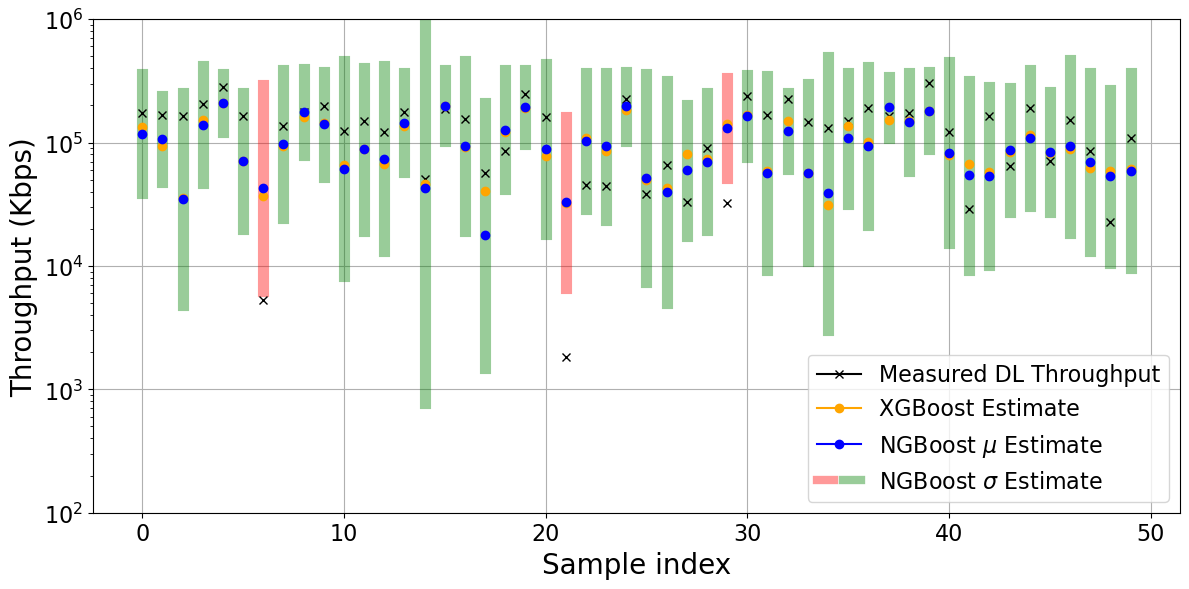

In [8]:
# Evaluación
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_dist = ngb_model.pred_dist(X_test)
y_test_pred_m = y_test_pred_dist.mean()
y_test_pred_s = y_test_pred_dist.std()

y_test_nat = np.expm1(y_test * s + m)

y_test_pred_xgb_nat = np.expm1(y_test_pred_xgb * s + m)
y_test_pred_m_log = y_test_pred_dist.mean()
y_test_pred_s_log = y_test_pred_dist.std()
y_test_pred_m_nat = np.expm1(y_test_pred_m_log * s + m)
y_test_pred_m_nat_lb = np.expm1((y_test_pred_m_log - z * y_test_pred_s_log) * s + m)
y_test_pred_m_nat_ub = np.expm1((y_test_pred_m_log + z * y_test_pred_s_log) * s + m)

# Visualización de ICs para DISPLAY_N muestras
DISPLAY_N = 50
idx = np.random.choice(len(X_test), DISPLAY_N, replace=False)

fig, ax = plt.subplots(figsize=(12, 6))
for i, j in enumerate(idx):
    xgb_pred_i = y_test_pred_xgb_nat[j]
    mu_i = y_test_pred_m_log[j]
    std_i = y_test_pred_s_log[j]
    y_true = y_test_nat[j]

    lower_i = y_test_pred_m_nat_lb[j]
    upper_i = y_test_pred_m_nat_ub[j]
    inside = lower_i <= y_true <= upper_i
    color = 'green' if inside else 'red'

    ax.plot([i, i], [lower_i, upper_i], color=color, linewidth=8, alpha = 0.4)
    ax.plot(i, y_true, marker='x', color='black', label='Measured DL Throughput' if i == 0 else "")
    ax.plot(i, xgb_pred_i, marker='o', color='orange', alpha = 1, label='XGBoost Estimate' if i == 0 else "")
    ax.plot(i, np.expm1(mu_i * s + m), marker='o', color='blue', alpha = 1, label=r'NGBoost $\mu$ Estimate' if i == 0 else "")

# Existing legend from plot
handles, labels = ax.get_legend_handles_labels()

# Custom handle for NGBoost σ (red–green line)
sigma_handle = mlines.Line2D([], [], color='red', linewidth=6, alpha=0.4)
sigma_handle2 = mlines.Line2D([], [], color='green', linewidth=6, alpha=0.4)

# Put both on top of each other (hack: treat as a single entry by grouping)
handles.append((sigma_handle, sigma_handle2))
labels.append(r'NGBoost $\sigma$ Estimate')

ax.legend(handles, labels, fontsize=16, handler_map={tuple: HandlerTuple(ndivide=None)})

# Larger labels
ax.set_xlabel("Sample index", fontsize=20)
ax.set_ylabel("Throughput (Kbps)", fontsize=20)

# Larger tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.set_ylim([100, 10**6])
ax.grid(True)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(folder_dir, 'Fig1.5G_SA_CIs.pdf'), 
            format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.close(fig)

## Fig 4. Calibration Curves

In [ ]:
def get_alphas_coverage(model, X, y, alphas=np.linspace(0.01, 0.99, 25)):

    dist_test = model.pred_dist(X)
    means = dist_test.mean().flatten()
    stds  = dist_test.std().flatten()

    coverage = []
    interval_length = []
    for alpha in alphas:
        z = scipy.stats.norm.ppf(0.5 + alpha/2)
        lower = means - z * stds
        upper = means + z * stds
        inside = (y.squeeze() >= lower) & (y.squeeze() <= upper)
        coverage.append(np.mean(inside))
        interval_length.append((upper - lower).mean())

    diff = np.array(coverage) - alphas
    ece = np.trapz(np.abs(diff), alphas)

    return alphas, coverage, ece, interval_length

4G 0.9 0.9129062865464816
5G_NSA 0.9 0.916958041958042
5G_SA 0.9 0.9016393442622951


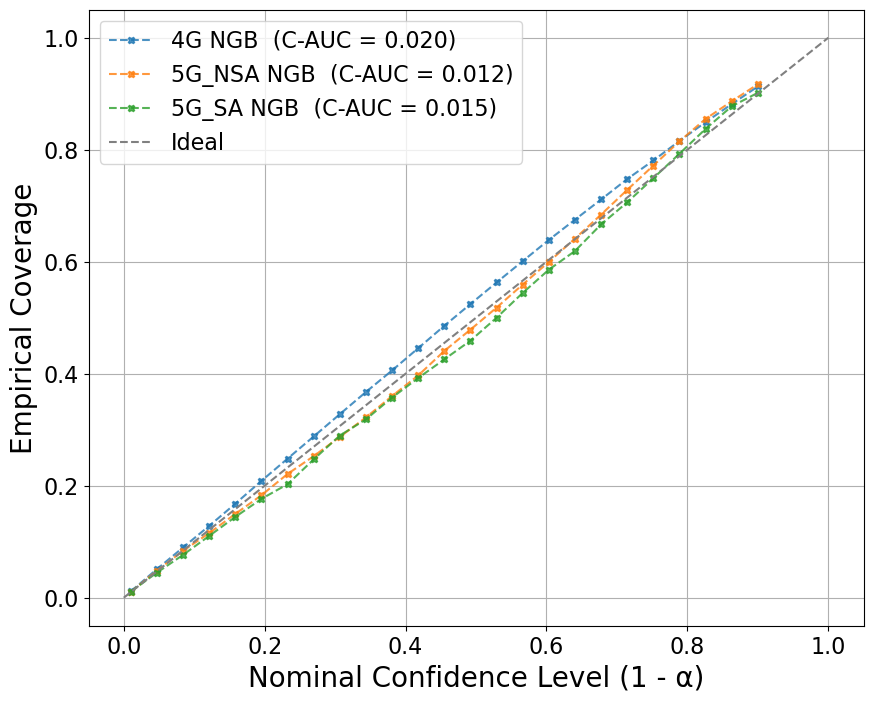

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for tech in model_data_dict:

    alphas, coverage, ece, interval_length = get_alphas_coverage(model_data_dict[tech]['ngb_model'], 
                                    model_data_dict[tech]['X_test'], 
                                    model_data_dict[tech]['y_test'])
    ax.plot(alphas, coverage, markersize = 5, marker='X',
                alpha=0.8, linestyle = '--', label=tech + ' NGB ' + f' (C-AUC = {ece:.3f})')

ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Ideal')

ax.set_xlabel("Nominal Confidence Level (1 - α)", fontsize=20)
ax.set_ylabel("Empirical Coverage", fontsize=20)

# Larger tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.grid(True)
ax.legend(fontsize=16)

plt.show()

fig.savefig(os.path.join(folder_dir, 'Fig2.Cal_curves.pdf'), 
            format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.close(fig)

## Fig 6. SHAP heatmap

In [ ]:
# Define color palettes for each group
from matplotlib import cm
from itertools import cycle
import matplotlib.patches as mpatches

In [ ]:
# Order by feature groups
features_order = ['Frequency Band', 'Carrier',
                  'RSRP', 'RSRQ', 'SINR', 'Timing Advance',
                  'Latency', 'Jitter', 'Packet Loss', 'DL TTFB',
                  'Time of the Day', 'Day of the Week']

In [14]:
shap_name_lst = [item for item in model_data_dict['5G_NSA'].keys() if '_shap' in item and not 'X_shap' in item] 

In [15]:
cols = []
col_to_shap_name_dict = {}
for key in dir_dict.keys():
    cols.append(key + '_XGB')
    col_to_shap_name_dict['XGB'] = 'xgb_shap'
    cols.append(key + '_NGB_MEAN')
    col_to_shap_name_dict['NGB_MEAN'] = 'ngb_shap_mean'
    cols.append(key + '_NGB_STD')
    col_to_shap_name_dict['NGB_STD'] = 'ngb_shap_std'

In [16]:
df = pd.DataFrame(columns = cols, 
                  index = model_data_dict['5G_NSA']['shap_features'])

In [17]:
for tech in model_data_dict.keys():
    for col_name in cols:
        if not col_name.startswith(tech):
            continue
        shap_name = col_to_shap_name_dict[col_name[len(tech)+1:]]
        df[col_name] = np.abs(model_data_dict[tech][shap_name].values).mean(axis = 0)

In [20]:
tech = '5G_SA'

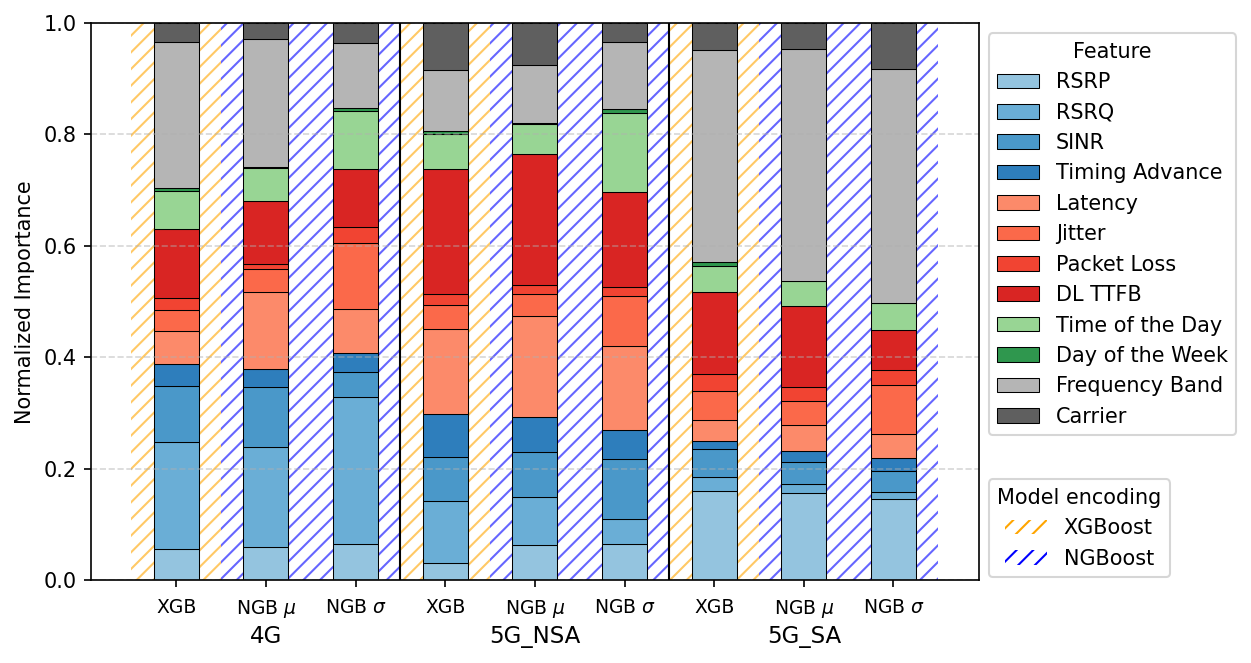

In [ ]:
deployment = ['Frequency Band', 'Carrier']
radio = ['RSRP', 'RSRQ', 'SINR', 'Timing Advance']
e2e = ['Latency', 'Jitter', 'Packet Loss', 'DL TTFB']
context = ['Time of the Day', 'Day of the Week']

features_order = radio + e2e + context + deployment

color_map = {}

color_map.update({f: c for f, c in zip(deployment, cm.Greys(np.linspace(0.4, 0.7, len(deployment))))})
color_map.update({f: c for f, c in zip(radio, cm.Blues(np.linspace(0.4, 0.7, len(radio))))})
color_map.update({f: c for f, c in zip(e2e, cm.Reds(np.linspace(0.4, 0.7, len(e2e))))})
color_map.update({f: c for f, c in zip(context, cm.Greens(np.linspace(0.4, 0.7, len(context))))})

df_vals = df.astype(float)

first_model = df_vals.columns[0]
top_features = df_vals[first_model].nlargest(20).index

df_top = df_vals.loc[top_features]
df_top = df_top.loc[features_order]

df_norm = df_top.div(df_vals.sum(axis=0), axis=1)

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

bottom_vals = np.zeros(len(df_norm.columns))
for feature in df_norm.index:
    ax.bar(df_norm.columns, df_norm.loc[feature],
           bottom=bottom_vals,
           label=feature,
           color=color_map[feature],   # same mapping as before
           edgecolor='black', linewidth=0.5,
           width=0.5)
    bottom_vals += df_norm.loc[feature].values

ax.axvline(x=2.5, color='black', linestyle='-', linewidth=1)  # between 3rd and 4th ticks
ax.axvline(x=5.5, color='black', linestyle='-', linewidth=1)  # between 6th and 7th ticks

ax.axvspan(-0.5, 0.5, facecolor='none', edgecolor='orange',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.axvspan(0.5, 2.5, facecolor='none', edgecolor='blue',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.axvspan(2.5, 3.5, facecolor='none', edgecolor='orange',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.axvspan(3.5, 5.5, facecolor='none', edgecolor='blue',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.axvspan(5.5, 6.5, facecolor='none', edgecolor='orange',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.axvspan(6.5, 8.5, facecolor='none', edgecolor='blue',
           hatch='///', alpha=0.6, linewidth=0.0, zorder=0)

ax.set_ylabel("Normalized Importance")
ax.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)

tick_labels = (['XGB', r'NGB $\mu$', r'NGB $\sigma$'] * 3)  # repeat 3 times
ax.set_xticks(np.arange(len(df_norm.columns)))
ax.set_xticklabels(tick_labels, rotation=0, fontsize=9)

ax.tick_params(axis='x', which='major', pad=5)  

group_labels = ['4G', '5G_NSA', '5G_SA']
group_sizes  = [3, 3, 3]  

pos = np.arange(len(df_norm.columns))
start = 0
for label, size in zip(group_labels, group_sizes):
    center = start + (size-1)/2
    ax.text(center, -0.08, label, ha='center', va='top',
            transform=ax.get_xaxis_transform(),
            fontsize=11)
    start += size

h_xgb = mpatches.Patch(facecolor='none', edgecolor='orange',
                       hatch='///', label='XGBoost', linewidth=0.0)
h_ngb = mpatches.Patch(facecolor='none', edgecolor='blue',
                       hatch='///', label='NGBoost', linewidth=0.0)

feat_legend = ax.legend(title="Feature", bbox_to_anchor=(1, 1), loc='upper left')

model_legend = ax.legend(handles=[h_xgb, h_ngb], title="Model encoding",
                         bbox_to_anchor=(1, 0.2), loc='upper left', frameon=True)
ax.add_artist(feat_legend)

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(folder_dir, 'Fig3.Feature_importance.pdf'), 
            format='pdf', bbox_inches='tight', pad_inches=0.05, bbox_extra_artists = (feat_legend, model_legend, ax))
plt.close(fig)

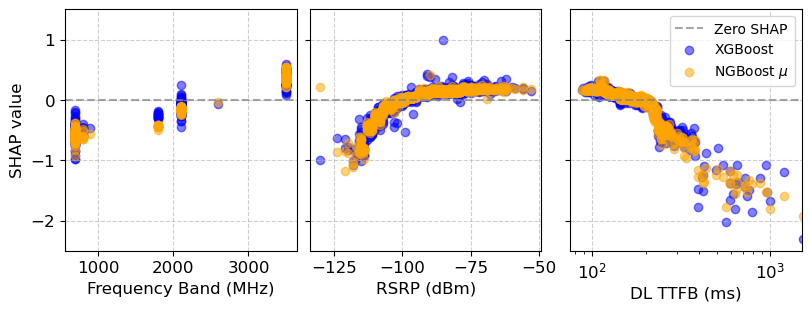

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True, constrained_layout=True)

fontsize = 12

X_shap = model_data_dict[tech]['X_shap']
xgb_shap = model_data_dict[tech]['xgb_shap']
ngboost_shap_mean = model_data_dict[tech]['ngb_shap_mean']

for idx, feature_name in enumerate(['Frequency Band', 'RSRP', 'DL TTFB']):

    feature_idx_shap = list(shap_features).index(feature_name)
    feature_idx_x = list(features).index(feature_name)

    axs[idx].axhline(0, color='gray', linestyle='--', alpha=0.7, label='Zero SHAP')

    axs[idx].scatter(X_shap[:, feature_idx_x], xgb_shap.values[:, feature_idx_shap],
                color='blue', alpha=0.5, label='XGBoost')
    axs[idx].scatter(X_shap[:, feature_idx_x], ngboost_shap_mean.values[:, feature_idx_shap],
                color='orange', alpha=0.5, label=r'NGBoost $\mu$')

    # axis labels
    if feature_name == 'RSRP':
        axs[idx].set_xlabel(feature_name + ' (dBm)', fontsize=fontsize)
    elif feature_name == 'Frequency Band':
        axs[idx].set_xlabel(feature_name + ' (MHz)', fontsize=fontsize)
    elif feature_name == 'DL TTFB':
        axs[idx].set_xlabel(feature_name + ' (ms)', fontsize=fontsize)

    axs[idx].set_ylim([-2.5, 1.5])

    if feature_name == 'DL TTFB':
        axs[idx].set_xscale('log')
        axs[idx].set_xlim([75, 1.5e3])

    axs[idx].grid(True, linestyle='--', alpha=0.6)

    # tick labels larger
    axs[idx].tick_params(axis='both', labelsize=fontsize)

# y-axis label
axs[0].set_ylabel('SHAP value', fontsize=fontsize)

# legend with larger font
axs[2].legend(fontsize=fontsize - 2)

plt.show()

fig.savefig(os.path.join(folder_dir, 'Fig4.SHAP_spread.pdf'),
            format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.close(fig)


In [25]:
df_norm.loc[e2e].sum(axis = 0) / df_norm.loc[radio].sum(axis = 0)

4G_XGB             0.626616
4G_NGB_MEAN        0.792500
4G_NGB_STD         0.805847
5G_NSA_XGB         1.476892
5G_NSA_NGB_MEAN    1.612714
5G_NSA_NGB_STD     1.584445
5G_SA_XGB          1.072486
5G_SA_NGB_MEAN     1.118693
5G_SA_NGB_STD      1.047129
dtype: float64

In [31]:
df_norm.loc['RSRQ'] / df_norm.loc[radio].sum(axis = 0)

4G_XGB             0.494029
4G_NGB_MEAN        0.472557
4G_NGB_STD         0.648151
5G_NSA_XGB         0.375590
5G_NSA_NGB_MEAN    0.292620
5G_NSA_NGB_STD     0.164744
5G_SA_XGB          0.098985
5G_SA_NGB_MEAN     0.066542
5G_SA_NGB_STD      0.052285
dtype: float64

In [32]:
df_norm.loc['RSRP'] / df_norm.loc[radio].sum(axis = 0)

4G_XGB             0.146557
4G_NGB_MEAN        0.157797
4G_NGB_STD         0.157700
5G_NSA_XGB         0.105196
5G_NSA_NGB_MEAN    0.219589
5G_NSA_NGB_STD     0.243535
5G_SA_XGB          0.644913
5G_SA_NGB_MEAN     0.676212
5G_SA_NGB_STD      0.669545
dtype: float64